In [41]:
# import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as geopd
import seaborn as sns

### Load Data

In [47]:
dfa_encode = pd.read_csv("Data/cleaned_house_records.csv")

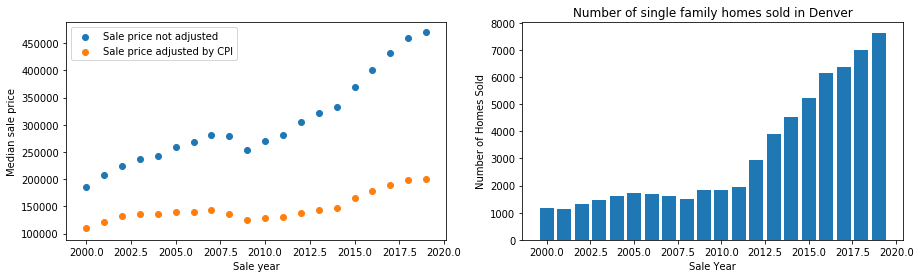

In [48]:
# Plot some feature distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

grouped = dfa_encode[['SALE_YEAR', 'SALE_PRICE', 'SALE_PRICE_CPI_ADJ']].groupby(['SALE_YEAR']).median().reset_index()

ax1.scatter(grouped.SALE_YEAR, grouped.SALE_PRICE, label = 'Sale price not adjusted')
ax1.scatter(grouped.SALE_YEAR, grouped.SALE_PRICE_CPI_ADJ, label = 'Sale price adjusted by CPI')
ax1.legend(prop={'size': 10})
ax1.set(xlabel='Sale year', ylabel='Median sale price')

#Column['SCHEDNUM'] (Assessment Parcel Schedule Number) is a unique number of each house sale. 
grouped = dfa_encode[['SALE_YEAR','SCHEDNUM']].groupby(['SALE_YEAR']).count().reset_index()
grouped.rename(columns = {"SCHEDNUM": "COUNT"}, inplace=True)

sale_year = [2000+i for i in range(20)]
ax2.bar(sale_year, grouped.COUNT)
ax2.set(xlabel='Sale Year', ylabel='Number of Homes Sold')
plt.title('Number of single family homes sold in Denver')

plt.show()

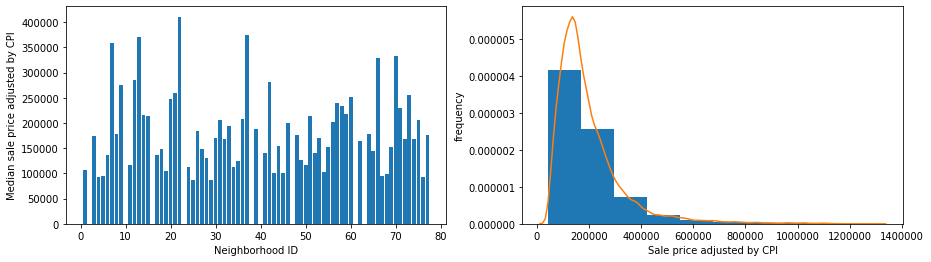

In [49]:
# Plot some feature distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

grouped = dfa_encode[['NBHD_ID', 'SALE_PRICE_CPI_ADJ']].groupby(['NBHD_ID']).median().reset_index()
grouped.rename(columns={'SALE_PRICE_CPI_ADJ': 'MEDIAN_SALE_PRICE_CPI_ADJ'}, inplace=True)

ax1.bar(grouped.NBHD_ID, grouped.MEDIAN_SALE_PRICE_CPI_ADJ)
ax1.set(xlabel='Neighborhood ID', ylabel='Median sale price adjusted by CPI')

ax2.hist(dfa_encode['SALE_PRICE_CPI_ADJ'], density=True)
ax2.set(xlabel = 'Sale price adjusted by CPI', ylabel = 'frequency')
sns.kdeplot(dfa_encode['SALE_PRICE_CPI_ADJ'], legend = False)

plt.show()

### Split data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer, MinMaxScaler

dfy = dfa_encode[['SALE_PRICE_CPI_ADJ']]
dfx = dfa_encode[dfa_encode.columns.difference(['SALE_PRICE_CPI_ADJ', 'POP_YEAR','SCHEDNUM'])]

# These columns are not selected in dfx_lr: ['BSMT_AREA', 'HOUSING_UN', 'NBHD_ID', 'Remodeled', 'SALE_PRICE','Unnamed: 0']
# Note: column['HOUSING_UN'] is the total number of houses in that house's neighborhood.
dfx_lr = dfx[['AGE', 'AREA_ABG', 'AVG_HH_INC', 'BACHELORSO', 'BED_RMS', 
              'CCAGE_RM', 'CCYRBLT', 'Colleges', 'Crimes', 'DrugDist', 'FBSMT_SQFT', 
              'FoodStores', 'GRD_AREA', 'BATH_RMS', 'Intersects', 
              'K12s', 'LAND_SQFT', 'LESSTHANHS', 'Libraries', 'Malls', 'Marijuana', 
              'MaxPctRace', 'MaxRaceTyp_BLACK', 'MaxRaceTyp_HISPAN', 'MaxRaceTyp_WHITE', 
              'PCT_AGE65P', 'PCT_AGELES', 'PER_CAPITA',
              'PCT_SOLD', 'PCT_VAC', 'PER_COMM', 'ParkDist', 
              'Park_Coverage', 'SALE_MONTH', 'SALE_YEAR', 'STORY', 
              'StLights', 'StoreDist', 'TrAccident', 'Tree_Coverage']]

scaler = MinMaxScaler()
transformer = PowerTransformer(method = 'box-cox', standardize = False)
# x data are scaled to range from 0 to 1.
# y data are box-cox transformed to be more Gaussian-like
dfx_trans = scaler.fit_transform(dfx_lr)
dfy_trans = transformer.fit_transform(dfy)

### Lasso Regression Model 1 using Box-cox Transformed y

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV

x_train, x_test, y_train, y_test = train_test_split(dfx_trans, dfy_trans, 
                                                    test_size = 0.25, random_state = 42, stratify = dfx['NBHD_ID'])


epss = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
rmses = []

for eps in epss: 
    regr = LassoCV(eps = eps, n_alphas = 200, cv = 10)

    #regr = TransformedTargetRegressor(regressor = lasso, transformer = transformer)
    regr.fit(x_train, y_train.ravel())
    y_pred = regr.predict(x_test)

    # inverse transform to get the actural root mean squared error
    y_pred_or = transformer.inverse_transform(y_pred.reshape(-1, 1))
    y_test_or = transformer.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_or, y_pred_or))
    rmses += [rmse]

print('Lowest Root Mean Squared Error: %d at eps of %.4f' % (np.min(rmses), epss[np.argmin(rmses)]))

C:\Users\haoxu\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008489548346444664, tolerance: 0.006347901723196118
  positive)
C:\Users\haoxu\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01644201238955212, tolerance: 0.006347901723196118
  positive)


Lowest Root Mean Squared Error: 79073 at eps of 0.0100


In [14]:
# select the parameter with best result
regr = LassoCV(eps = epss[np.argmin(rmses)], n_alphas = 200, cv = 10)

#regr = TransformedTargetRegressor(regressor = lasso, transformer = transformer)
regr.fit(x_train, y_train.ravel())
y_train_pred = regr.predict(x_train)
y_pred = regr.predict(x_test)

# inverse transform to get the actural root mean squared error
y_train_pred_or = transformer.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_or = transformer.inverse_transform(y_train.reshape(-1, 1))
y_pred_or = transformer.inverse_transform(y_pred.reshape(-1, 1))
y_test_or = transformer.inverse_transform(y_test.reshape(-1, 1))

print('Train Root Mean Squared Error: %d' % np.sqrt(mean_squared_error(y_train_or, y_train_pred_or)))
print('Train R squared: %.2f' % r2_score(y_train_or, y_train_pred_or))

print('Root Mean Squared Error: %d' % np.sqrt(mean_squared_error(y_test_or, y_pred_or)))
print("Median absolute error: %.2f" % median_absolute_error(y_test_or, y_pred_or))
print('Test R squared: %.2f' % r2_score(y_test_or, y_pred_or))

factors = dfx_lr.columns
factor_coefs = zip(factors, regr.coef_)

print('Lasso Parameters: \nAlpha: {0:.4f} \n'.format(regr.alpha_))
print('Factor, Coefficient')
coef = [print('%s, %.4f' %(f, c)) for f, c in sorted(factor_coefs, key = lambda x: -abs(x[1])) if c != 0]

Train Root Mean Squared Error: 99991
Train R squared: 0.43
Root Mean Squared Error: 79073
Median absolute error: 24582.33
Test R squared: 0.63
Lasso Parameters: 
Alpha: 0.0001 

Factor, Coefficient
AREA_ABG, 0.1618
PCT_SOLD, 0.0471
BATH_RMS, 0.0461
PER_CAPITA, 0.0362
FBSMT_SQFT, 0.0302
Intersects, -0.0242
PCT_AGELES, -0.0198
StLights, 0.0184
SALE_YEAR, 0.0180
DrugDist, -0.0104
LESSTHANHS, -0.0100
MaxRaceTyp_HISPAN, -0.0073
BACHELORSO, 0.0067
STORY, 0.0065
CCAGE_RM, 0.0058
Malls, -0.0058
MaxPctRace, 0.0056
K12s, 0.0033
SALE_MONTH, 0.0033
TrAccident, 0.0024
AGE, 0.0017
Libraries, -0.0006


### Lasso Regression Model 2 using y without Box-cox Transformation (code is shown as follows)

* Compared to model 1, model 2 gives a higher test R squared (0.70 compared to 0.63), a lower root mean squared error (~73 K compared to ~79K) and a larger number of coefficents (37 compared to 22).

#### Lasso Regression Model 3 = Lasso Regression Model 2 + without Stratified Sampling Training data x (code not shown)

* Compared to model 2, model 3 gives a similar result: the test R squared (0.70), a similar root mean squared error (~73 K) and the same number of coefficents (37). 

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV

x_train, x_test, y_train, y_test = train_test_split(dfx_trans, dfy, 
                                                    test_size = 0.25, random_state = 42, stratify = dfx['NBHD_ID'])


epss = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
rmses = []

for eps in epss: 
    regr = LassoCV(eps = eps, n_alphas = 200, cv = 10)

    #regr = TransformedTargetRegressor(regressor = lasso, transformer = transformer)
    regr.fit(x_train, y_train.values.ravel())
    y_pred = regr.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses += [rmse]

print('Lowest Root Mean Squared Error: %d at eps of %.4f' % (np.min(rmses), epss[np.argmin(rmses)]))

C:\Users\haoxu\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1105336304199.9688, tolerance: 82327171692.00407
  positive)


Lowest Root Mean Squared Error: 72679 at eps of 0.0005


In [16]:
# select the parameter with best result
regr = LassoCV(eps = epss[np.argmin(rmses)], n_alphas = 200, cv = 10)

#regr = TransformedTargetRegressor(regressor = lasso, transformer = transformer)
regr.fit(x_train, y_train.values.ravel())
y_train_pred = regr.predict(x_train)
y_pred = regr.predict(x_test)

print('Train Root Mean Squared Error: %d' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Train R squared: %.2f' % r2_score(y_train, y_train_pred))

print('Root Mean Squared Error: %d' % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, y_pred))
print('Test R squared: %.2f' % r2_score(y_test, y_pred))

factors = dfx_lr.columns
factor_coefs = zip(factors, regr.coef_)

print('Lasso Parameters: \nAlpha: {0:.4f} \n'.format(regr.alpha_))
print('Factor, Coefficient')
coef = [print('%s, %.4f' %(f, c)) for f, c in sorted(factor_coefs, key = lambda x: -abs(x[1])) if c != 0]


Train Root Mean Squared Error: 72073
Train R squared: 0.70
Root Mean Squared Error: 72679
Median absolute error: 29329.12
Test R squared: 0.69
Lasso Parameters: 
Alpha: 12.8303 

Factor, Coefficient
AREA_ABG, 1087091.2577
BED_RMS, -169312.7356
PER_CAPITA, 150812.8566
BATH_RMS, 143769.2323
Intersects, -122901.8427
FBSMT_SQFT, 120792.9443
PCT_SOLD, 110286.9929
GRD_AREA, 68121.6742
StLights, 61146.5630
SALE_YEAR, 59864.1311
AVG_HH_INC, 44195.0233
TrAccident, 37146.7121
PCT_AGE65P, -36180.9244
PCT_AGELES, -33341.7551
FoodStores, 29657.6797
Tree_Coverage, 29595.4756
K12s, 29515.6239
Marijuana, -26637.2714
MaxPctRace, 23068.7058
DrugDist, -21914.5106
MaxRaceTyp_BLACK, 21711.3625
BACHELORSO, -20815.2128
LESSTHANHS, -19314.5724
Park_Coverage, 18298.3098
Malls, -18053.7283
Crimes, -15065.8449
Colleges, -14500.9574
StoreDist, -12423.6041
ParkDist, -10670.0939
CCYRBLT, 8324.4438
CCAGE_RM, 8322.2611
SALE_MONTH, 6859.0230
Libraries, -2718.7764
STORY, -2568.2267
PER_COMM, -2263.0648
PCT_VAC, -1996.5

### Bagging Forest Model 1 with 10 Trees

In [42]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#dfx_rf = dfx[['AREA_ABG', 'PCT_SOLD', 'BATH_RMS', 'BSMT_AREA', 'PER_CAPITA', 'PCT_AGELES', 
#              'SALE_YEAR', 'POPULATION', 'Intersects', 'BACHELORSO', 'DrugDist', 'STORY', 'MaxRaceTyp_HISPAN', 'StLights',
#             'Remodeled', 'Malls', 'TrAccident', 'MaxPctRace', 'K12s', 'AGE', 'GRD_AREA']]

x_train, x_test, y_train, y_test = train_test_split(dfx_lr, dfy, 
                                                    test_size = 0.25, random_state = 42, stratify = dfx['NBHD_ID'])

rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
rf.fit(x_train, y_train.values.ravel())
y_pred = rf.predict(x_test)

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, y_pred))
print("R Squared with Random Forest: %.2f" % r2_score(y_test, y_pred))

RMSE: 51233.56
Median absolute error: 15580.22
R Squared with Random Forest: 0.85


### Bagging/Random Forest Model parameters Tuning

In [18]:
rf = RandomForestRegressor(random_state = 42)

params ={
 'max_depth': [None, 16],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 1000]}

rf_search = GridSearchCV(estimator = rf, param_grid = params, cv = 3, verbose=2, n_jobs = -1)

rf_search.fit(x_train, y_train.values.ravel())

rf_search.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  6.7min remaining:   36.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  7.0min finished


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000}

In [48]:
rf_cv_results = zip(rf_search.cv_results_['rank_test_score'], rf_search.cv_results_['mean_test_score'],
                    rf_search.cv_results_['mean_fit_time'], rf_search.cv_results_['params'])

print('Test_score_rank, mean_test_score, mean_fit_time, params')

cv_results_print = [print('%s\t\t %.4f\t\t %.1f\t\t %s' %(r, s, t, p)) 
                    for r, s, t, p in sorted(rf_cv_results, key = lambda x: x[0])]

Test_score_rank, mean_test_score, mean_fit_time, params
1		 0.8396		 387.5		 {'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000}
2		 0.8387		 312.8		 {'max_depth': 16, 'max_features': 'auto', 'n_estimators': 1000}
3		 0.8384		 81.5		 {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 1000}
4		 0.8373		 39.2		 {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
5		 0.8365		 7.3		 {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
6		 0.8365		 34.2		 {'max_depth': 16, 'max_features': 'auto', 'n_estimators': 100}
7		 0.8343		 57.9		 {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 1000}
8		 0.8326		 5.9		 {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 100}


#### Bagging/Random Forest Model 2 using 1000 Trees + without Stratified Sampling Training data x (code not shown)
* Compared to model 1, model 2 gives a slightly better result: the R squared (0.85), a lower root mean squared error (~50K compared to ~51K). 

### Bagging/Random Forest Model 3 using 1000 Trees

* Compared to model 2, model 3 gives a better result: a bigger R squared (0.86 compared to 0.85), a lower root mean squared error (~48K compared to ~50K). 

In [169]:
x_train, x_test, y_train, y_test = train_test_split(dfx_lr, dfy, 
                                                    test_size = 0.25, random_state = 42, stratify = dfx['NBHD_ID'])

rf = RandomForestRegressor(max_depth = None, max_features = 'auto', n_estimators = 1000, random_state = 42)
rf.fit(x_train, y_train.values.ravel())
y_pred = rf.predict(x_test)

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, y_pred))
print("R Squared with Random Forest: %.2f" % r2_score(y_test, y_pred))

importances = list(rf.feature_importances_)
features = list(dfx_lr.columns)

feature_importance = [(f, i) for f, i in zip(features, importances)]
feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)
print("Features and Importances: ")
s = [print("{0:s}: {1:4.3f}".format(*p)) for p in feature_importance if p[1] > 0.01]

RMSE: 48454.23
Median absolute error: 14541.10
R Squared with Random Forest: 0.86
Features and Importances: 
AREA_ABG: 0.431
PER_CAPITA: 0.114
AVG_HH_INC: 0.095
SALE_YEAR: 0.071
AGE: 0.033
FBSMT_SQFT: 0.023
PCT_AGELES: 0.022
MaxPctRace: 0.020
SALE_MONTH: 0.019
StoreDist: 0.019
LAND_SQFT: 0.018
CCYRBLT: 0.016
DrugDist: 0.016
ParkDist: 0.016
PCT_SOLD: 0.013
BATH_RMS: 0.011
K12s: 0.010


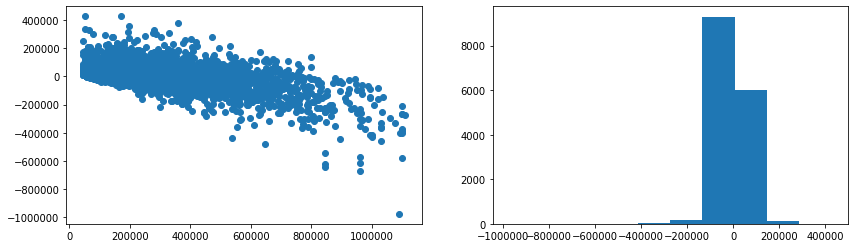

In [46]:
# random forest errors
errors = y_test.copy()
errors['predicted'] = y_pred
errors['error'] = errors['predicted'] - errors['SALE_PRICE_CPI_ADJ']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
ax1.scatter(errors['SALE_PRICE_CPI_ADJ'], errors['error'])
ax2.hist(errors['error'])
plt.show()

### Artificial Neural Network Preparation

In [49]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from keras import backend as K
from keras.optimizers import SGD

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

x_train, x_test, y_train, y_test = train_test_split(dfx_trans, dfy, 
                                                    test_size = 0.25, random_state = 42, stratify = dfx['NBHD_ID'])

Using TensorFlow backend.


### Artificial Neural Network Model 1 using Three Layers Structure (60, 30, 60) + Adamax optimizer

In [160]:
# ANN using a structure in three layers(60, 30, 60)
# Initialising the ANN
nn_regressor = Sequential()
input_dim = x_train.shape[1]

# Adding the input layer and the first hidden layer
nn_regressor.add(Dense(output_dim = 60, init = 'he_uniform',activation='relu',input_dim = input_dim))

# Adding the second hidden layer
nn_regressor.add(Dense(output_dim = 30, init = 'he_uniform',activation='relu'))

# Adding the third hidden layer
nn_regressor.add(Dense(output_dim = 60, init = 'he_uniform',activation='relu'))

# Adding the output layer.
# Adding activation='sigmoid' in the outlayer gives the same result.
nn_regressor.add(Dense(output_dim = 1, init = 'he_uniform'))

# Compiling the ANN
nn_regressor.compile(loss = root_mean_squared_error, optimizer = 'Adamax')

# Fitting the ANN to the standarized training set
model_history = nn_regressor.fit(x_train, y_train.values, validation_split = 0.20, 
                               batch_size = 10, epochs = 60, verbose = 0)

# Three layers (100, 50, 100) was tested: R squared was the same (0.69), RMSE was slightly worse (73840.04)
# Three layers (60, 30, 15) was tested: R squared was the same (0.69), RMSE was slightly worse (73342.51)

ann_pred = nn_regressor.predict(x_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, ann_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, ann_pred))
print("R Squared: %.2f" % r2_score(y_test, ann_pred))

C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=40, units=60, kernel_initializer="he_uniform")`
  import sys
C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=30, kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=60, kernel_initializer="he_uniform")`
  del sys.path[0]
C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, kernel_initializer="he_uniform")`


RMSE: 73169.04
Median absolute error: 28936.67
R Squared: 0.69


#### Artificial Neural Network Model 2 using Two Layers Structure (60, 60) + RMSprop Optimizer (code not shown)

* Compared to model 1, model 2 gives a similar result: the same R squared (0.69), and the same root mean squared error (~73K). 

### Random Forest Model 3 using Two Layers Structure (60, 60) + Adamax optimizer

* Compared to model 2, model 3 gives a slightly better result: the same R squared (0.69), and a lower root mean squared error (~72K compared to ~73K). 

In [164]:
# ANN using a structure in two layers(60, 60)
# Initialising the ANN
nn_regressor = Sequential()
input_dim = x_train.shape[1]

# Adding the input layer and the first hidden layer
nn_regressor.add(Dense(output_dim = 60, init = 'he_uniform',activation='relu',input_dim = input_dim))

# Adding the second hidden layer
nn_regressor.add(Dense(output_dim = 60, init = 'he_uniform',activation='relu'))

# Adding the output layer
nn_regressor.add(Dense(output_dim = 1, init = 'he_uniform'))

# Compiling the ANN
nn_regressor.compile(loss = root_mean_squared_error, optimizer = 'Adamax')

# Fitting the ANN to the standarized training set
model_history = nn_regressor.fit(x_train, y_train.values, validation_split = 0.20, batch_size = 10, epochs = 60, verbose = 0)

# Two layers (30, 30) was tested: R squared was the same (0.69), RMSE was slightly worse (72867.32) 

ann_pred = nn_regressor.predict(x_test)
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, ann_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, ann_pred))
print("R Squared: %.2f" % r2_score(y_test, ann_pred))

C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=40, units=60, kernel_initializer="he_uniform")`
  import sys
C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=60, kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\haoxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, kernel_initializer="he_uniform")`
  del sys.path[0]


RMSE: 72272.43
Median absolute error: 28583.41
R Squared: 0.69


# XGBoost Model

### XGBoost Model Preparation

In [198]:
import xgboost as xgb
from scipy.stats import uniform, randint

x_train, x_test, y_train, y_test = train_test_split(dfx_lr, dfy, 
                                                    test_size = 0.25, random_state = 42, stratify = dfx['NBHD_ID'])

### XGBoost Model 1

In [172]:
model_xgb = xgb.XGBRegressor()

model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, y_pred))
print("R Squared with XGBoost: %.2f" % r2_score(y_test, y_pred))

[22:40:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 57647.76
Median absolute error: 18184.95
R Squared with XGBoost: 0.80


### XGBoost Model Hyperparameters Tuning

In [201]:
regressor=xgb.XGBRegressor()

## Hyper Parameter Optimization

n_estimators = [100, 150]
max_depth = [2, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=3, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 8,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(x_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   34.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:  1.7min finished


[23:15:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                                          verbosity=1),
                   iid='warn', n_iter=50, n_jobs=8,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
     

In [202]:
random_cv.best_estimator_

XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=2, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### XGBoost Model 2
* Compared to model 1, model 2 shows a better result: R Squared is 0.87 compared to 0.80, and RMSE is ~47k compared to ~58K.

### XGBoost Model is the Best Model Compared to Other Trained Models (Lasso, Random Forest, Neural Network)

In [203]:
model_xgb = xgb.XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.82,
             gamma=0.17, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.19,
             max_delta_step=0, max_depth=9, min_child_weight=2, 
             monotone_constraints=None, n_estimators=128, n_jobs=-1,
             num_parallel_tree=5, objective='reg:squarederror', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.79, tree_method=None,
             validate_parameters=False, verbosity=None)

model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Median absolute error: %.2f" % median_absolute_error(y_test, y_pred))
print("R Squared with XGBoost: %.2f" % r2_score(y_test, y_pred))

model_xgb.save_model('Models/model_xgb_regressor.model')

# To be done later
# tree_method='auto' from None
# gpu_id=0 from -1

[23:16:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 46846.04
Median absolute error: 14217.91
R Squared with XGBoost: 0.87
